## Libs

In [32]:
import pandas as pd 
import yfinance as yf 
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import talib
import bt

In [ ]:
data = yf.download('AAPL' , start = '2023-01-01',end ='2024-12-31' )
data.columns = data.columns.get_level_values(0) #because multindex , need 1D for candleStick


C:\Users\mayah\AppData\Local\Temp\ipykernel_13044\2873263530.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('AAPL' , start = '2023-01-01',end ='2024-12-31' )
[*********************100%***********************]  1 of 1 completed

In [ ]:
def plotLowAndHigh (data_frame) :
    
    plt.figure(figsize=(8,4))
    plt.plot(data_frame['Low'], color = 'red')
    plt.plot(data_frame['High'], color = 'green')
    plt.title('low and high ')
    plt.show()    

In [10]:
def plotCandles(data_frame):
    candlestick = go.Candlestick(
    x=data_frame.index,
    open=data_frame['Open'],
    high=data_frame['High'],
    low=data_frame['Low'],
    close=data_frame['Close'])
    fig = go.Figure(candlestick)
    fig.update_layout(title='prices')                        
    fig.show()



In [11]:
plotCandles(data)

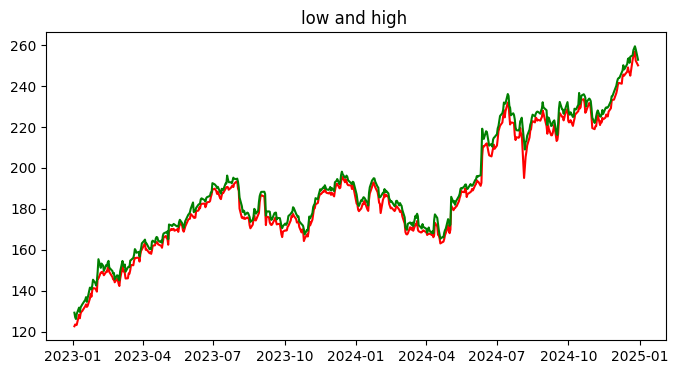

In [46]:
plotLowAndHigh(data )

In [ ]:
#SWING TRADER (BY WEEK)
data_weekly = data.resample('W').mean()

In [ ]:
#calculatin daily return 
data['daily_return'] = data['Close'].pct_change()*100

In [20]:
# Plot the histogram
def dailyHistogram(data_frame):
    data_frame['daily_return'].hist(bins=100, color='red')
    plt.ylabel('Frequency')
    plt.xlabel('Daily return')
    plt.title('Daily return histogram')
    plt.show()

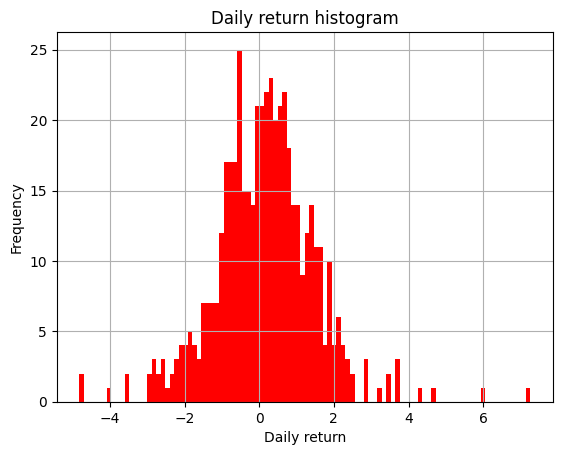

In [21]:
dailyHistogram(data)

In [25]:

def sma(data_frame , period ):
    data_frame[f"sma {period}"] = data_frame['Close'].rolling(window=period).mean()
    plt.plot(data_frame[f"sma {period}"], color='green', label=f"sma{period}")
    plt.plot(data_frame['Close'], color='red', label='Close')
    plt.title('Simple moving averages')
    plt.legend()
    plt.show()

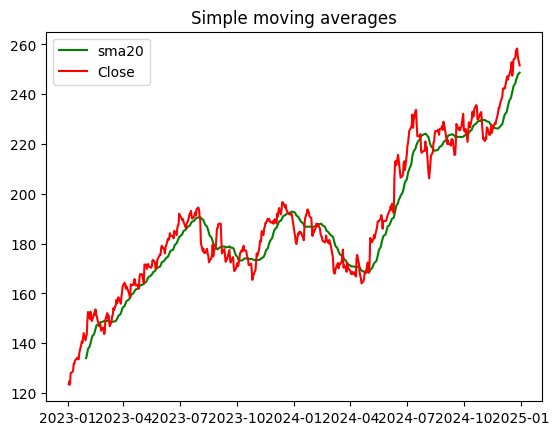

In [26]:
sma(data,20)

In [ ]:
data['RSI_14'] = talib.RSI(data['Close']) #by default time period 
data['RSI_21'] = talib.RSI(data['Close'], timeperiod = 21)
print(data.tail())

Price            Close        High         Low        Open    Volume  \
Date                                                                   
2024-12-23  254.655716  255.034791  252.840088  254.156919  40858800   
2024-12-24  257.578674  257.588630  254.675658  254.875189  23234700   
2024-12-26  258.396667  259.474086  257.010028  257.568678  27237100   
2024-12-27  254.974930  258.077462  252.451019  257.209530  42355300   
2024-12-30  251.593094  252.889969  250.146586  251.623020  35557500   

Price       daily_return      sma_20      sma 20     RSI_14     RSI_21  
Date                                                                    
2024-12-23      0.306495  244.437349  244.437349  73.085638  69.849128  
2024-12-24      1.147808  245.700803  245.700803  75.750272  71.897166  
2024-12-26      0.317570  246.895920  246.895920  76.452864  72.447114  
2024-12-27     -1.324219  247.926434  247.926434  67.626263  66.712977  
2024-12-30     -1.326341  248.668144  248.668144  60.2255

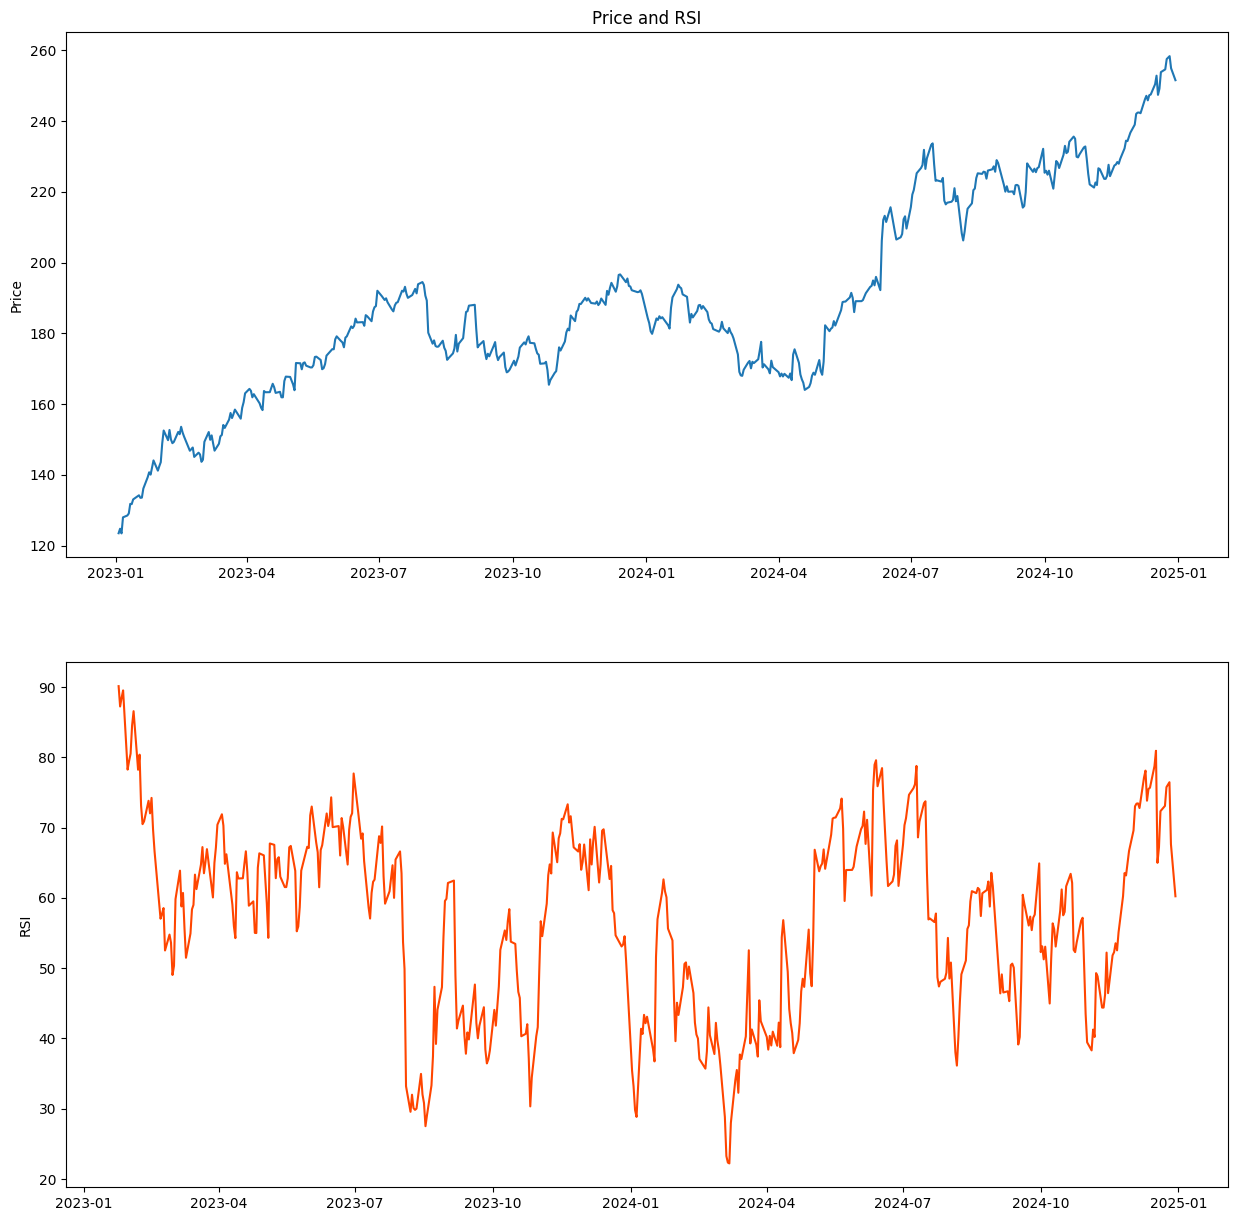

In [ ]:
# Calculate RSI
data['RSI'] = talib.RSI(data['Close'])
fig, (ax1, ax2) = plt.subplots(2, figsize=(15,15))
ax1.set_ylabel('Price')
ax1.plot(data['Close'])
ax2.set_ylabel('RSI')
ax2.plot(data['RSI'], color='orangered')
ax1.set_title('Price and RSI')
plt.show()

stock_rsi = talib.RSI(data)

In [40]:
data_clean = data.dropna()
prices = data_clean[['Close']].copy()
prices.columns = ['AAPL']

In [ ]:
# Define the strategy 
bt_strategy = bt.Strategy('Trade_Weekly', 
[bt.algos.RunWeekly(), # Run weekly 
bt.algos.SelectAll(), # Use all data 
bt.algos.WeighEqually(), # Maintain equal weights 
bt.algos.Rebalance()]) # Rebalance


In [42]:
# Backtest
bt_test = bt.Backtest(bt_strategy, prices)
result = bt.run(bt_test)
result.display()

100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

Stat                 Trade_Weekly
-------------------  --------------
Start                2023-02-01
End                  2024-12-30
Risk-free rate       0.00%

Total Return         68.97%
Daily Sharpe         1.41
Daily Sortino        2.49
CAGR                 31.59%
Max Drawdown         -16.61%
Calmar Ratio         1.90

MTD                  6.27%
3m                   8.36%
6m                   20.01%
YTD                  31.63%
1Y                   31.63%
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  31.59%

Daily Sharpe         1.41
Daily Sortino        2.49
Daily Mean (ann.)    29.79%
Daily Vol (ann.)     21.18%
Daily Skew           0.26
Daily Kurt           3.05
Best Day             7.26%
Worst Day            -4.82%

Monthly Sharpe       1.55
Monthly Sortino      3.92
Monthly Mean (ann.)  32.17%
Monthly Vol (ann.)   20.81%
Monthly Skew         0.06
Monthly Kurt         -0.73
Best Month           13.02%
Worst Month          -8.87%

Year